In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install  torch-lr-finder

## Importing the goodies and defining some paths 


In [4]:
import torch
import torchvision
import torch.nn as nn                                                
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
from IPython.display import clear_output
from torchvision.transforms import ToTensor
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
import cv2
import time
from tqdm.notebook import tqdm
import torchvision.datasets as datasets
import os
from numpy import moveaxis
import pandas as pd

train_image_dir = "/content/drive/My Drive/kaggle/mind_the_bend/raw_images/"
test_image_dir = "/content/drive/My Drive/kaggle/mind_the_bend/test/"
ROOT = "/content/drive/My Drive/kaggle/mind_the_bend/"

# numpy image: H x W x C
# torch image: C X H X W

In [5]:
!cp  /content/drive/"My Drive"/kaggle/mind_the_bend/new_vertices.tar.gz /content/ 
!cp  /content/drive/"My Drive"/kaggle/mind_the_bend/new_vertices_test.tar.gz /content/ 

In [6]:
!mkdir raw_images
!tar -xf /content/new_vertices.tar.gz -C /content/raw_images

!mkdir raw_images_test
!tar -xf /content/new_vertices_test.tar.gz -C /content/raw_images_test

# Generate a CSV file containing the labels 
* The labels are the first three characters of the image name 



In [125]:
def  generate_csv(source_folder, save_path):
    
    final_stack = []
    for i in tqdm(os.listdir(source_folder)):   # i is the img_name btw
        filename = i
        label = i[:3]
        if label == "Cop":
            label = i[8:11]
        final_stack.append([filename, 400 - int(label)])
    final_stack = np.array(final_stack)

    np.savetxt(save_path , final_stack, delimiter=",", fmt = "%s")
    print("saved --", save_path)

In [ ]:
generate_csv("/content/raw_images/", ROOT + "train_labels.csv")
generate_csv("/content/raw_images_test/", ROOT + "test_labels.csv")

## Balancing training data with the `RandomOverSampler()`

In [127]:
df = pd.read_csv(ROOT + "train_labels.csv")
df_test = pd.read_csv(ROOT + "test_labels.csv")
df_test.columns = ['filename', "label"]
df_test.to_csv(ROOT + "test_labels.csv", index = False)

In [128]:
X = df[df.columns[0]].values.reshape(-1,1)
y = df[df.columns[1]].values
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(X, y)

In [129]:
x_vals  = np.array(x_resampled.reshape(1,-1)[0])
y_vals = np.array(y_resampled)

In [130]:
new_list = []
for i in range(len(x_vals)):
    new_list.append([  x_vals[i], y_vals[i] ])
new_df = pd.DataFrame(new_list)
new_df.columns = ["filename", "label"]
new_df.to_csv(ROOT + 'balanced_labels.csv', index = False)

## Comparing the distributions of balance and unbalanced data 

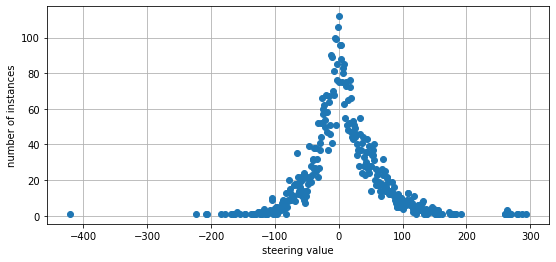

In [135]:
plt.plot(df[df.columns[1]].value_counts(), "o")
plt.xlabel("steering value")
plt.ylabel("number of instances")
plt.grid()
plt.show()

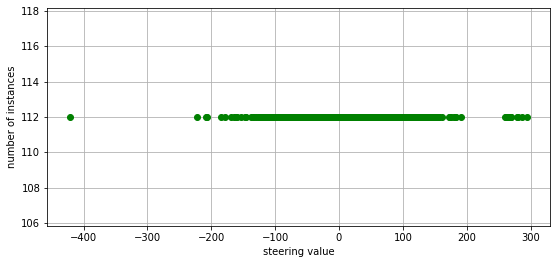

In [136]:
plt.plot(new_df[new_df.columns[1]].value_counts(), "go")
plt.xlabel("steering value")
plt.ylabel("number of instances")
plt.grid()
plt.show()

In [103]:
def img_to_arr(im_path):
    img = Image.open(im_path)
    x = np.array(img)
    return x

def segment_road_on_np(image, lower_gray = [0, 5, 4], higher_gray = [179, 50, 90]):
    img = (image).astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_gray = np.array(lower_gray, np.uint8)
    upper_gray = np.array(higher_gray, np.uint8)
    mask_gray = cv2.inRange(hsv, lower_gray, upper_gray)
    img_res = cv2.bitwise_and(img, img, mask = mask_gray)
    return img_res

def fill_voids(img_np):
    kernel = np.ones((3,3),np.uint8)
    img = cv2.morphologyEx(img_np, cv2.MORPH_CLOSE, kernel, iterations = 3)
    return img

In [104]:
df = pd.read_csv(ROOT + "test_labels.csv")
df.head()

,filename,label
0,389_FPV_seed_37__836.png,11
1,381_FPV_seed_740__919.png,19
2,409_FPV_seed_834__957.png,-9
3,417_FPV_seed_431__1071.png,-17
4,397_FPV_seed_910__1654.png,3


## Custom DataLoader class whic would be compatible with image folders and CSV files 


In [105]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, image_folder_path, csv_file_path , transform = None, segment_road = False):

        self.transform = transform

        print("Loading CSV from:  ", csv_file_path)
        print("Loading images from:  ", image_folder_path)

        self.segment_road = segment_road
        self.image_folder_path = image_folder_path

        self.labels = pd.read_csv(csv_file_path)['label'].values
        self.filenames = pd.read_csv(csv_file_path)["filename"].values

    def __getitem__(self, item):

        label = self.labels[item]
        
        filename = self.filenames[item]
        # print(filename)

        img = img_to_arr(self.image_folder_path + "/" + filename)

        if self.segment_road == True:
            img = fill_voids(segment_road_on_np(img))

        
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.tensor([label])

    def __len__(self):
        return len(self.labels)

In [106]:
train_set = MyDataset("/content/raw_images/", ROOT + "balanced_labels.csv", segment_road = True,
              transform =transforms.Compose([          
                                                transforms.ToPILImage(),
                                                torchvision.transforms.RandomAffine(degrees = 5, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                ToTensor()
                                           ])
              )
test_set = MyDataset("/content/raw_images_test/", ROOT + "test_labels.csv", segment_road = True,
              transform =transforms.Compose([  
                                             
                                            ToTensor()
                                           ])
              )

Loading CSV from:   /content/drive/My Drive/kaggle/mind_the_bend/balanced_labels.csv
Loading images from:   /content/raw_images/
Loading CSV from:   /content/drive/My Drive/kaggle/mind_the_bend/test_labels.csv
Loading images from:   /content/raw_images_test/


## Loading up the training data in a batches

In [107]:
train_batch_size = 80
test_batch_size = 4
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_set, batch_size =test_batch_size)
print(len(train_loader), "batches ")
print(len(test_loader), " batches ")

436 batches 
436  batches 


## Viewing some samples from training data 

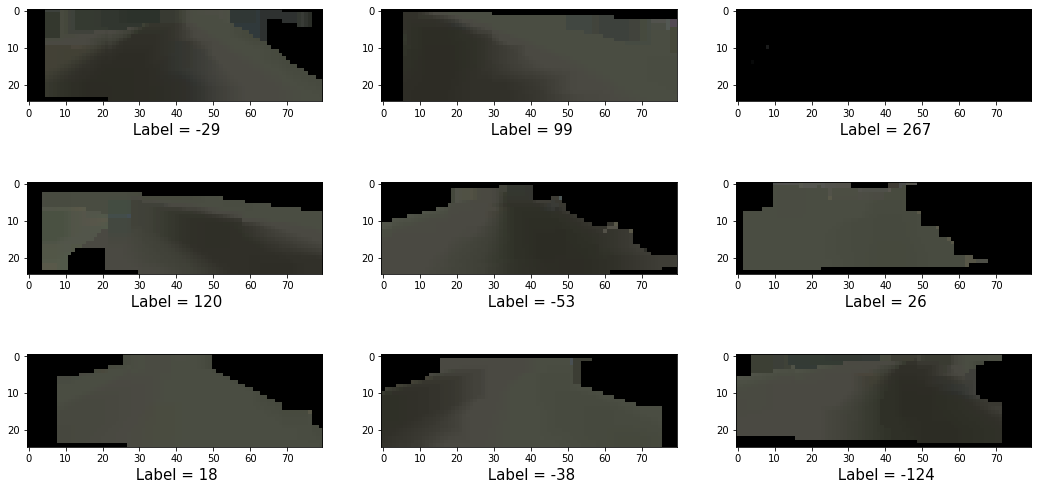

In [108]:
sample = next(iter(train_loader))
image_batch, labels = sample
fig, ax = plt.subplots(3,3, figsize = (18,9))
c = 0
for i in range (3):
    for j in range (3):
    
        # res = drunk_driver(image_batch[c].cuda().unsqueeze(0)).item()
        image_np = image_batch[c].squeeze(0).squeeze(0).numpy()
        image_mvaxis = moveaxis(image_np, 0,2)
        
        ax[i,j].imshow(image_mvaxis)
        x =  " Label = " + str(labels[c].item())
        ax[i,j].set_xlabel(x, fontsize= 15)
        c += 1

## Utils for metrics collection

In [109]:
def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_acc(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Accuracy")
    plt.ylabel("Acc ", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

In [110]:
def calculate_accuracy_on_validation_set(cellnet, test_set):

    val_loader =  DataLoader(dataset=test_set, batch_size=1, shuffle = True)
    cellnet.eval()
    preds = []
    vals = []
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            pred = cellnet(x_val.cuda())  # pred
            total += 1
            preds.append(pred.item())
            vals.append(y_val.item())
            if -30 < pred.item() - y_val.item() < 30:
                correct += 1
        return ((correct/total)*100)

## Training loop

In [111]:

def train_step(x, y, model, optimizer):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = F.mse_loss(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()

def train_model(config):

    epochs = config["epochs"]
    cellnet = config["cellnet"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    lr = config["lr"]

    optimizer = optim.Adam(cellnet.parameters(), lr = lr) 

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=6, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    accuracies = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)

        current_acc = calculate_accuracy_on_validation_set(cellnet, test_set)
        accuracies.append(current_acc)
        show_acc(accuracies)

        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =cellnet(x_val.cuda())  # pred 
                val_loss = F.mse_loss(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 

                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())
        cellnet.train()
       
        for batch in tqdm(train_loader, desc = " Training batches : "):


                (x_batch, y_batch) = batch
                loss = train_step(x_batch.cuda(), y_batch.cuda(), cellnet, optimizer)
                losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)
    show_acc(accuracies)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return accuracies


## The CNN

In [120]:

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(16, 32 , 3, padding = 1)
        # self.conv3 = nn.Conv2d(64, 64 , 3, padding = 1)

        
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = (self.pool(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.pool(F.relu(self.conv3(x)))


        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x =F.relu(self.fc3(x))

        x = self.fc4(x)

        return x

drunk_driver = Net()
drunk_driver.apply(weights_init)
drunk_driver = drunk_driver.cuda()
print(drunk_driver)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


## Finding the best learning rate 

In [113]:
config = { "epochs" : 5, 
          
          "cellnet" : drunk_driver, 
                    
          "train_loader" : train_loader, 
          
          "val_loader" : test_loader,

          "lr" : 0.025
        }

def experiment_with_lr(lower_lr, upper_lr, num_samples, train_func, config, epochs_per_experiment):

    experiment_accuracies = []
    config["epochs"] = epochs_per_experiment
    
    for lr in np.linspace(lower_lr , upper_lr, num_samples):
        config["lr"] = lr ## new lr 

        config["cellnet"].apply(weights_init)  ## reset model

        accs = train_func(config)
        experiment_accuracies.append([lr, accs])
    return experiment_accuracies

In [ ]:
accs = experiment_with_lr(lower_lr = 0.0001, upper_lr = 0.01, num_samples = 10, train_func = train_model, config = config, epochs_per_experiment = 15)

## Plotting the training curves after testing out on various learning rates 

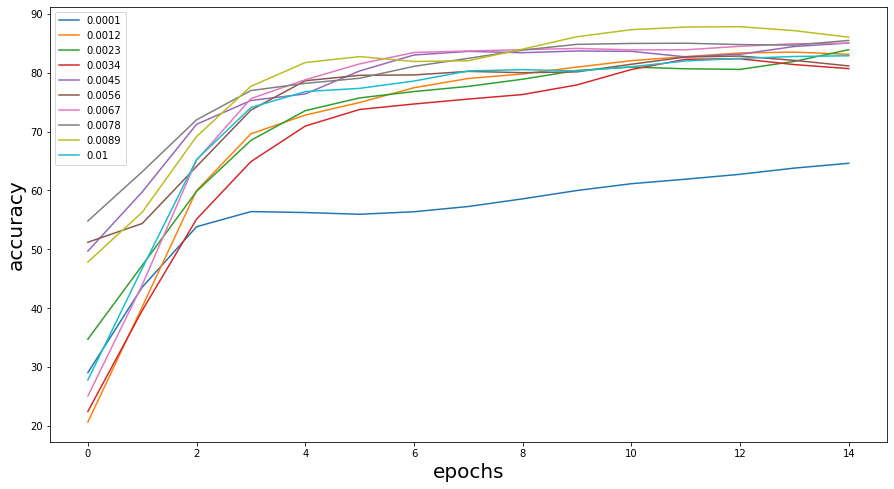

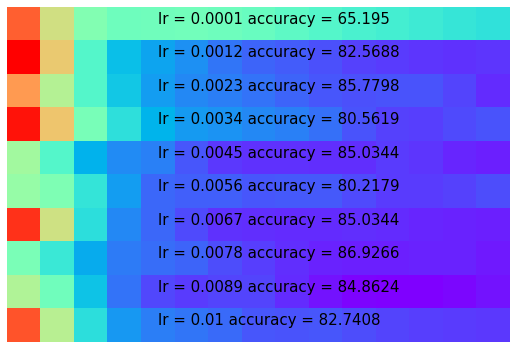

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
for i in accs:

    ac = gaussian_filter1d(i[1], sigma=1)
    last_point = [8,  ac[-1]]
    lr = round(i[0], 9)
    plt.plot(ac, label = str(lr))

plt.legend()
plt.ylabel("accuracy", fontsize = 20)
plt.xlabel("epochs", fontsize = 20)
plt.show()

rows = []
x = 0

plt.figure(figsize = (9,20))
for i in accs:

    ac = gaussian_filter1d(i[1], sigma=1)
    rows.append(ac)r-
    lab = "lr = " + str(round(i[0], 5)) + " accuracy = " + str(round(i[1][-1], 4))
    plt.text(4, x, lab, fontsize = 15)
    x+= 1
    
plt.axis("off")
plt.set_cmap("rainbow_r")
plt.imshow(rows)
plt.show()

## Final training 

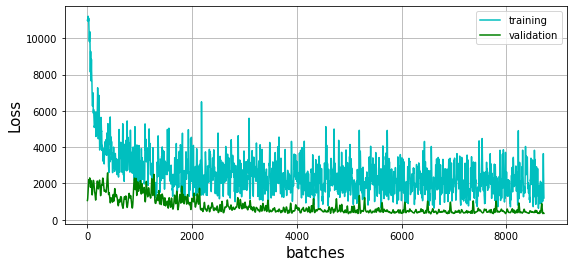

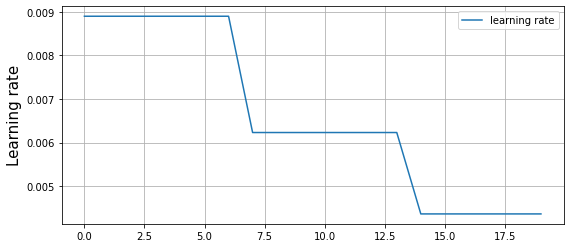

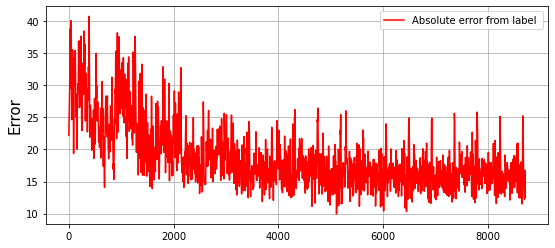

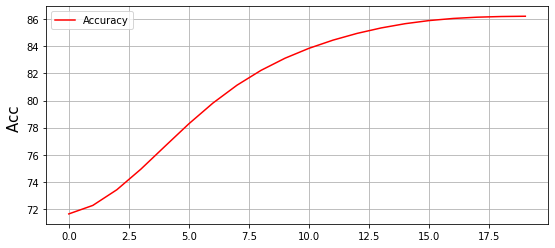

Time elapsed =  212.91718981399998  seconds


In [121]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
    "epochs" : 20,    
    "cellnet" : drunk_driver,      
    "train_loader" : train_loader, 
    "val_loader" : test_loader,
    "lr" : 0.0089
     }

accuracies = train_model(config)

In [122]:
torch.save(drunk_driver.state_dict(), ROOT + "drunk_driver.pt")
torch.save(drunk_driver.state_dict(), "drunk_driver.pt")

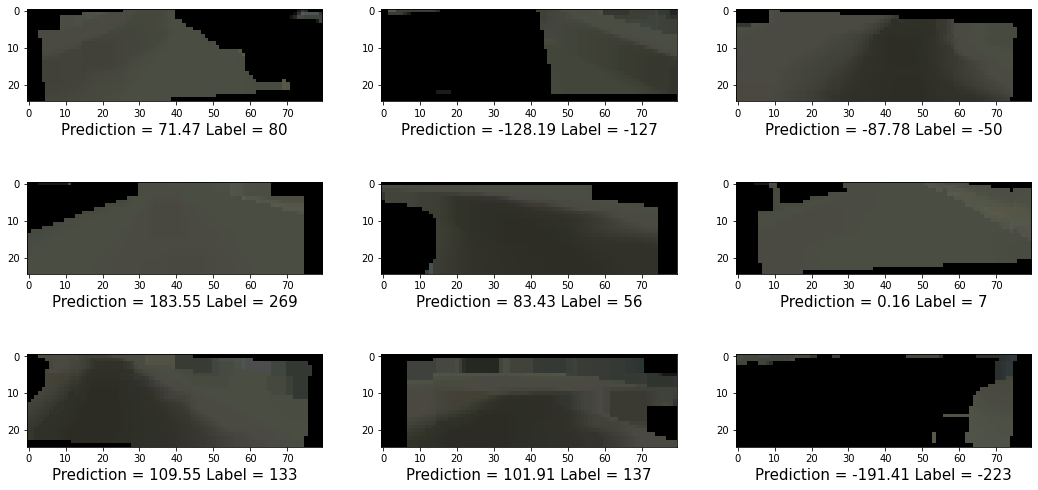

In [123]:
sample = next(iter(train_loader))
image_batch, labels = sample
fig, ax = plt.subplots(3,3, figsize = (18,9))

c = 0
for i in range (3):
    for j in range (3):

        res = drunk_driver(image_batch[c].cuda().unsqueeze(0)).item()
        image_np = image_batch[c].squeeze(0).squeeze(0).numpy()
        image_mvaxis = moveaxis(image_np, 0,2)
        
        ax[i,j].imshow(image_mvaxis)
        x = "Prediction = " +  str(round(res,2)) + " Label = " + str(labels[c].item())
        ax[i,j].set_xlabel(x, fontsize= 15)
        c+=1